## Table of contents:
* [Loading data](#loading-data)
* [Compute calibration](#compute-calibration)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure

import sys
sys.path.append('../../Libraries/GCMProject')
sys.path.append('../../Libraries')
sys.path.append('../core')
sys.path.append('..')

from core import gcm_erm, data, erm
from overlaps import Overlaps, average_overlaps
import core.calibration
calibration = core.calibration
import datalogging
import utility
import json
from experiments import overlap_erm_bo, joint_density, display

%load_ext autoreload
%autoreload 2

### Plot for $\tau = 0.5$ <a class="anchor" id="loading-data"></a>

In [15]:
# NOTE : Here, the values of optimal lambda (error and loss) are hardcoded for simplicity

alphas = [0.1, 0.3, 0.64444444, 0.77777778, 1.25555556, 1.73333333, 2.21111111, 2.27777778, 2.68888889, 2.82222222, 3.36666667, 3.91111111, 4.12222222, 4.45555556, 4.6, 5., 5.5, 5.94444444]
alphas_loss = [0.1, 0.3, 0.64444444, 0.77777778, 1.18888889, 1.25555556, 1.73333333, 1.73333333, 2.21111111, 2.27777778, 2.68888889, 2.82222222
, 3.16666667, 3.36666667, 3.64444444, 3.91111111, 4.12222222, 4.45555556, 4.6, 5.5, 5.94444444]

lambdas_error = [0.15707089, 0.15192841, 0.14269407, 0.13949883, 0.13070956, 0.12294952, 0.11767612, 0.11685053, 0.11335602, 0.11262331, 0.10818084, 0.10682432, 0.1059374, 0.10404697, 0.10382364, 0.10194337, 0.101381, 0.10053462]
lambdas_loss  = [0.24993965, 0.23108275, 0.20510443, 0.19612455, 0.17472299, 0.17183171,
 0.15519736, 0.15519736, 0.14325259, 0.14169219, 0.13406006, 0.13207289,
 0.1278976,  0.12577201, 0.12251133, 0.11987922, 0.11830503, 0.11566855,
 0.1150262,  0.11003591, 0.10810678]


In [12]:
sigma = 0.5
alphas, lambdas_error, error_list, loss_list = datalogging.try_loading_lambda_from_csv(sigma, '../../../UncertaintyNN/Code/experiments_results/lambda_search/lambda_search.csv', include_errors = True)
alphas_loss, lambdas_loss, error_list_loss, loss_list_loss = datalogging.try_loading_lambda_from_csv(sigma, '../../../UncertaintyNN/Code/experiments_results/lambda_search/lambda_search_loss.csv', include_errors = True)

alphas, alphas_loss, lambdas_error, lambdas_loss = np.array(alphas), np.array(alphas_loss), np.array(lambdas_error), np.array(lambdas_loss)
error_list, loss_list, error_list_loss, loss_list_loss = np.array(error_list), np.array(loss_list), np.array(error_list_loss), np.array(loss_list_loss)

idx = np.argsort(alphas)
alphas, lambdas_error = alphas[idx], lambdas_error[idx]
error_list, loss_list = error_list[idx], loss_list[idx]
idx = np.argsort(alphas_loss)

alphas_loss, lambdas_loss = alphas_loss[idx], lambdas_loss[idx]
error_list_loss, loss_list_loss = error_list_loss[idx], loss_list_loss[idx]

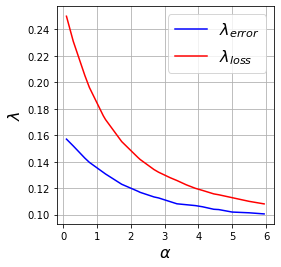

In [16]:
fig = plt.figure()
ax = fig.add_subplot()

plt.plot(alphas, lambdas_error, 'b', label='$\\lambda_{error}$')
try:
    plt.plot(alphas_loss, lambdas_loss, 'r', label='$\\lambda_{loss}$')
except Exception as e:
    print(e)
    
ax.set_aspect(1./ax.get_data_ratio())

# plt.title(f'Optimal $\\lambda$ $\\sigma$ = {sigma}')

plt.xlabel('$\\alpha$', fontsize=16)
plt.ylabel('$\\lambda$', fontsize=16)
plt.grid()



plt.legend(fontsize=16)
plt.savefig('Figures/optimal_lambda_tau_0.5.pdf')
plt.show()

### Compute overlaps

In [20]:
def compute_overlaps(alphas, lambdas, sigma, ntrials : int = 10):
    d = 500
    
    overlaps = []
    for (a, l) in zip(alphas, lambdas):
        print(a, l)
        ov = overlap_erm_bo.get_average_theoretical_separate_overlap_reduced(a, l, sigma, ntrials, precision = 1e-5, code_version = 'gcm', d=d) 
        overlaps.append(ov)
    return overlaps

In [29]:
def load_overlaps(alphas, lambdas, sigma):   
    filename = 'overlaps.csv'
    overlaps = []
    for (a, l) in zip(alphas, lambdas):
        res = datalogging.try_loading_overlaps_from_csv(a, sigma, l, filename, as_object = True)
        _, _, _, ov = res
        overlaps.append(ov)
    return overlaps

In [31]:
# Overlaps are pre-computed and saved in the file overlaps.csv
# You can load them by uncommenting the lines with ... load_overlaps ... 
# You can recompute them by uncommenting the lines with ... compute_overlaps ... 

overlaps_error = []
overlaps_loss  = []

k = len(alphas)
ntrials = 5

print(f'Sigma is {sigma}')

print('%%%%%% LAMBDA ERRROR %%% ')

# overlaps_error = compute_overlaps(alphas, lambdas_error, sigma, ntrials)
overlaps_error = load_overlaps(alphas, lambdas_error, sigma)

print('%%%%%% LAMBDA LOSSS %%% ')

# overlaps_loss = compute_overlaps(alphas_loss, lambdas_loss, sigma, ntrials)
overlaps_loss = load_overlaps(alphas_loss, lambdas_loss, sigma)


Sigma is 0.5
%%%%%% LAMBDA ERRROR %%% 
%%%%%% LAMBDA LOSSS %%% 


### Compute calibration <a class="anchor" id="compute-calibration"></a>

In [32]:
p = 0.75

In [33]:
# FOR THE ERROR 

k = len(alphas)
teacher_cals_list = np.zeros((k,))

for i in range(k):
    o = overlaps_error[i].__dict__
    m_list[i] = o['m']
    teacher_cals_list[i] = core.calibration.compute_teacher_calibration(p, o['rho'], o['qerm'], o['m'], sigma)
    
#### FOR THE LOSS

k = len(alphas_loss)
loss_teacher_cals_list = np.zeros((k,))
exp_loss_teacher_cals_list = np.zeros((k,))
loss_m_list    = np.zeros((k,))

for i in range(k):
    o = overlaps_loss[i].__dict__
    loss_m_list[i] = o['m']
    loss_teacher_cals_list[i] = core.calibration.compute_teacher_calibration(p, o['rho'], o['qerm'], o['m'], sigma)

In [35]:
# compute calibration fully experimentally 
# TAKES A LOT OF TIME TO RUN WITH N = 1000 TRIALS !!! 

full_exp_cals_list = []
std                = []
full_exp_loss_cals_list = []
loss_std = []

d     = 300
ntest = 50000
ntrials = 200

ex_alphas = alphas
ex_alphas_loss = alphas_loss
ex_lambdas_error = lambdas_error
ex_lambdas_loss  = lambdas_loss

for a, l in zip(ex_alphas, ex_lambdas_error):
    print(a, l)
    tmp_list = []
    for i in range(ntrials):
        w, X, y = data.sample_instance(d, a, 'probit', sig = sigma)
        werm = erm.erm_logistic_regression(X, y, l)
        Xtest, Ytest = data.sample_data(w, a, 'probit', sig = sigma)
        tmp_list.append(calibration.compute_experimental_teacher_calibration(p, w, werm, Xtest, Ytest, sigma))
    full_exp_cals_list.append(np.mean(tmp_list))
    print(' ... ', np.mean(tmp_list))
    std.append(np.std(tmp_list))
    
for a, l in zip(ex_alphas_loss, ex_lambdas_loss):
    print(a, l)
    tmp_list = []
    for i in range(ntrials):
        w, X, y = data.sample_instance(d, a, 'probit', sig = sigma)
        werm = erm.erm_logistic_regression(X, y, l)
        Xtest, Ytest = data.sample_data(w, a, 'probit', sig = sigma)
        tmp_list.append(calibration.compute_experimental_teacher_calibration(p, w, werm, Xtest, Ytest, sigma))
    full_exp_loss_cals_list.append(np.mean(tmp_list))
    loss_std.append(np.std(tmp_list))

0.1 0.15707089
 ...  nan
0.3 0.15192841
 ...  nan
0.64444444 0.14269407
 ...  0.03587993800155216
0.77777778 0.13949883
 ...  0.040339919370602786
1.25555556 0.13070956
 ...  0.037460289876721474
1.73333333 0.12294952
 ...  0.02693418942832041
2.21111111 0.11767612
 ...  0.025602395203284257
2.27777778 0.11685053
 ...  0.024166095757393334
2.68888889 0.11335602
 ...  0.03225860074647251
2.82222222 0.11262331
 ...  0.027147141769831126
3.36666667 0.10818084
 ...  0.027488606307138945
3.91111111 0.10682432
 ...  0.024635729941836458
4.12222222 0.1059374
 ...  0.02202764091927447
4.45555556 0.10404697
 ...  0.023035982942585728
4.6 0.10382364
 ...  0.020628508679181506
5.0 0.10194337
 ...  0.021916554699294738
5.5 0.101381
 ...  0.016627423649574608
5.94444444 0.10053462
 ...  0.015505005503360168
0.1 0.24993965
0.3 0.23108275
0.64444444 0.20510443
0.77777778 0.19612455
1.18888889 0.17472299
1.25555556 0.17183171
1.73333333 0.15519736
1.73333333 0.15519736
2.21111111 0.14325259
2.27777778

/var/folders/j2/fp7w_fyd3sbg73tfmz4s573c0000gn/T/ipykernel_22474/3594702334.py:10: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.errorbar(ex_alphas, full_exp_cals_list, yerr= np.array(std) / np.sqrt(ntrials), fmt='.', c='b', marker='x')
/var/folders/j2/fp7w_fyd3sbg73tfmz4s573c0000gn/T/ipykernel_22474/3594702334.py:11: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.errorbar(ex_alphas_loss, full_exp_loss_cals_list, yerr = np.array(loss_std) / np.sqrt(ntrials), fmt='.', marker='x', c='r')


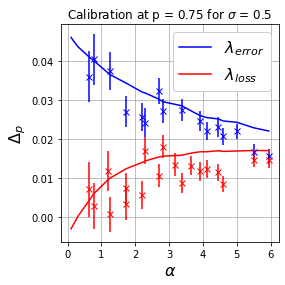

In [36]:


fig = plt.figure()
ax = fig.add_subplot()

plt.grid()
plt.title('Calibration at p = {:.2f} for $\\sigma$ = {}'.format(p, sigma))

plt.plot(alphas, teacher_cals_list, 'b', label='$\\lambda_{error}$')
plt.plot(alphas_loss, loss_teacher_cals_list, 'r', label='$\\lambda_{loss}$')

plt.errorbar(ex_alphas, full_exp_cals_list, yerr= np.array(std) / np.sqrt(ntrials), fmt='.', c='b', marker='x')
plt.errorbar(ex_alphas_loss, full_exp_loss_cals_list, yerr = np.array(loss_std) / np.sqrt(ntrials), fmt='.', marker='x', c='r')

legend = plt.legend(prop={'size':16})
legend.get_frame().set_alpha(1)
plt.xlabel('$\\alpha$', fontsize=16)
plt.ylabel('$\\Delta_p$', fontsize=16)
ax.set_aspect(1./ax.get_data_ratio())

# NOTE : Changer le sigma pour mettre sigma 0
plt.savefig('Figures/calibration_sigma_0.5.pdf', bbox_inches='tight')